# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import stats
import time_of_emergence_plots
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# from dask.distributed import Client
# client = Client()
# client

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [8]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [9]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [10]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [11]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [12]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

In [13]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

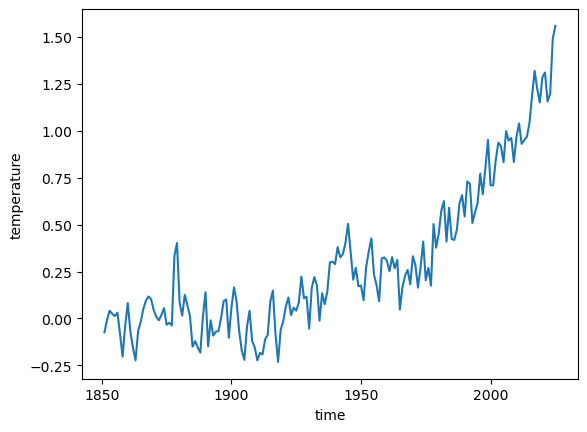

In [14]:
best_ds_smean.plot()

# Calculations

In [15]:
window = 20

## Signal-to-Noise

In [16]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=40)#method='POLYNOMIAL', order=4)#

In [17]:
noise_ds = base_period_ds.std(dim='time').to_numpy()
noise_ds

array(0.11661159)

In [18]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth#- base_period_ds_average

In [19]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 175)>
-0.3279 -0.3072 -0.2862 -0.2647 -0.2428 ... 10.81 11.02 11.23 11.43 11.64
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [20]:
ds_best_sn.attrs = {'longname': 'Signal-to-Noise Ratio'}

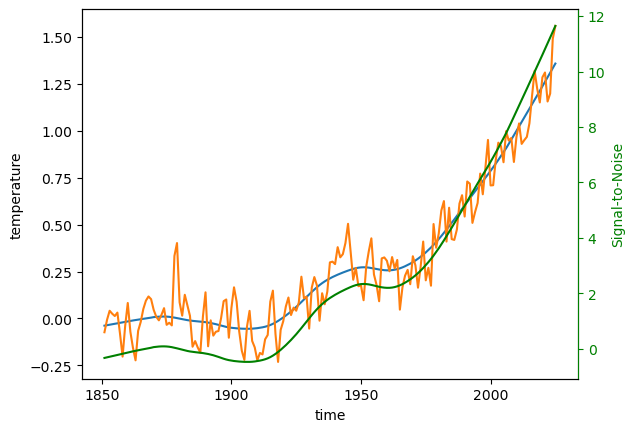

In [21]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_smooth.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

## p-value tests

In [22]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py'>

In [23]:
# This version is better
ks_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_anderson_pvalue)

In [24]:
ks_ds

<xarray.DataArray 'temperature' (time: 155)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00

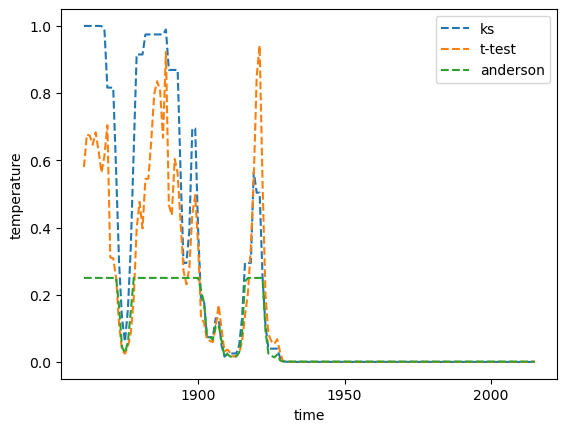

In [25]:
ks_ds.plot(label='ks', linestyle='--')
ttest_ds.plot(label='t-test', linestyle='--')
anderson_ds.plot(label='anderson', linestyle='--')

plt.legend()

# Getting ToE

In [26]:
PVALUE_THESHOLD1 = 0.01

In [27]:
ds_best_sn.name = 'signal_to_noise'
ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
anderson_ds.name = 'anderson'

In [28]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'

In [29]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn]).dropna(dim='time')

In [30]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds])

In [31]:
toe_ds

<xarray.Dataset>
Dimensions:          ()
Data variables:
    signal_to_noise  float64 1.94e+03
    ks               float64 1.928e+03
    ttest            float64 1.928e+03
    anderson         float64 1.927e+03
Attributes: (2)

# Plotting

In [37]:
time_of_emergence_plots.flip_pvalue(toe_metrics_ds['ks'].values)

array([6.92173085e-05, 6.92173085e-05, 6.92173085e-05, 6.92173085e-05,
       6.92173085e-05, 6.92173085e-05, 7.11893421e-04, 1.07754186e-02,
       1.83650671e-01, 1.83650671e-01, 1.83650671e-01, 4.33901451e-01,
       7.05500874e-01, 8.70089220e-01, 9.39780050e-01, 8.45126997e-01,
       6.59109892e-01, 3.71291466e-01, 8.50233800e-02, 8.50233800e-02,
       8.50233800e-02, 2.54698231e-02, 2.54698231e-02, 2.54698231e-02,
       2.54698231e-02, 2.54698231e-02, 2.54698231e-02, 2.54698231e-02,
       1.07754186e-02, 1.31026214e-01, 1.31026214e-01, 1.31026214e-01,
       1.31026214e-01, 4.33901451e-01, 7.05500874e-01, 7.05500874e-01,
       6.09159870e-01, 3.05528918e-01, 3.05528918e-01, 6.09159870e-01,
       8.16161196e-01, 8.16161196e-01, 9.26390055e-01, 9.26390055e-01,
       9.26390055e-01, 8.70089220e-01, 8.70089220e-01, 9.51155970e-01,
       9.84350040e-01, 9.74820467e-01, 9.74820467e-01, 9.74820467e-01,
       9.74820467e-01, 9.51155970e-01, 8.70089220e-01, 7.05500874e-01,
      

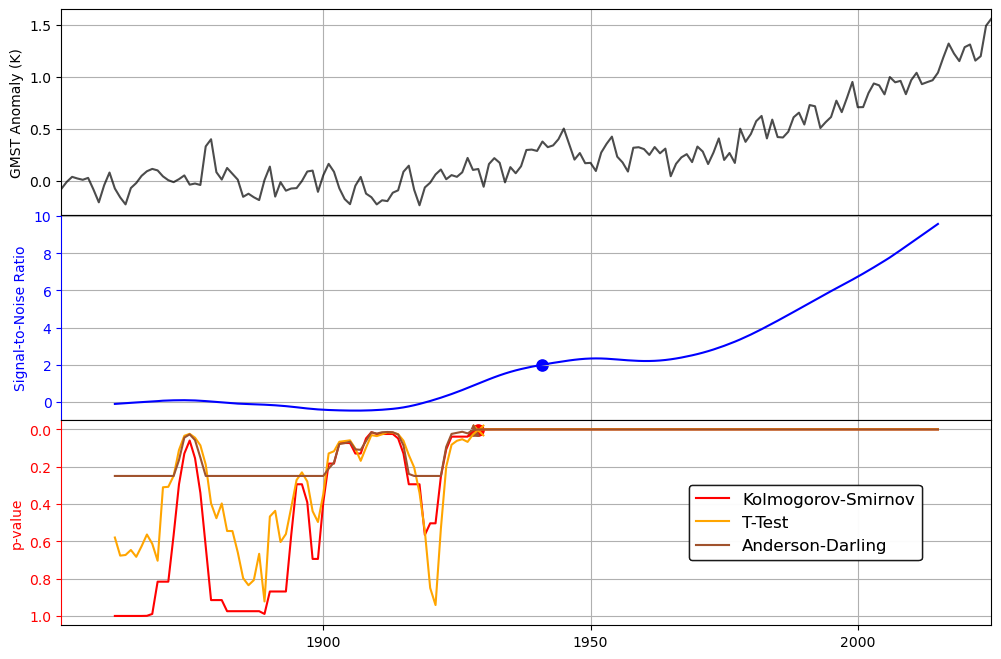

In [39]:
time_of_emergence_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'}
    )


In [33]:
central_year  = 1883
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-10, central_year+11)))

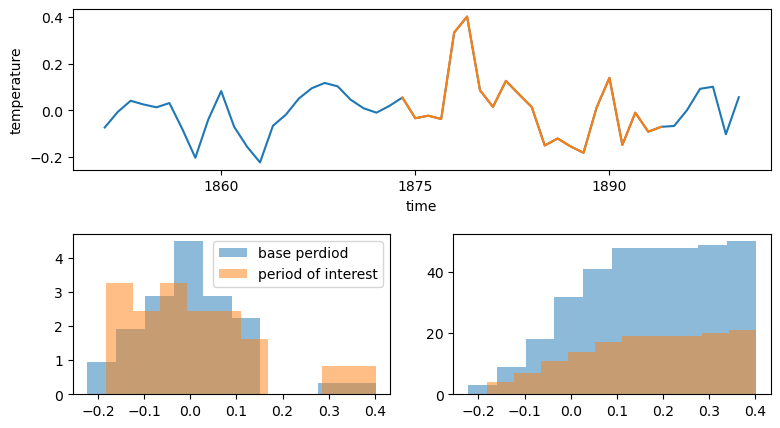

In [34]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);